In [ ]:
import os
import re
import zipfile
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm

!pip install mlxtend
!pip install tensorflow

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
  uploaded_files = files.upload()
else:
   uploaded_files = ["E:\diploma\In\_NanoData_LOGS_100_users_Platform.zip"]
uploaded_zip_path = None
for key in uploaded_files:
  uploaded_zip_path = key
  break
print(uploaded_zip_path)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import numpy as np

class LogAnalyzer:
    def __init__(self):
        self.tokenizer = None
        self.model = None
        self.max_seq_len = None
        self.block_categories = {
            'line': 'LINE',
            'circle': 'CIRCLE',
            'rectangle': 'RECTANGLE',
            'polygon': 'POLYGON',
            '3dpoly': '3DPOLY'
        }
        self.command_categories = {
          # Создание объектов
          'line': 'LINE',
          'circle': 'CIRCLE',
          'rectangle': 'RECTANGLE',
          'arc': 'ARC',
          'polygon': 'POLYGON',
          'spline': 'SPLINE',
          'ellipse': 'ELLIPSE',
          '3dpoly': '3DPOLY',
          'xline': 'LINE',
          'ray': 'LINE',
          'revcloud': 'POLYGON',

          # Редактирование объектов
          'move': 'MOVE',
          'copy': 'COPY',
          'rotate': 'ROTATE',
          'scale': 'SCALE',
          'mirror': 'MIRROR',
          'stretch': 'STRETCH',
          'erase': 'ERASE',
          'delete': 'ERASE',
          'fillet': 'FILLET',
          'mfillet': 'FILLET',
          'offset': 'OFFSET',
          'vcoffsetcmd': 'OFFSET',
          'trim': 'TRIM',
          'lengthen': 'EXTEND',
          'explode': 'ERASE',
          'join': 'EDIT',

          # Слои и свойства
          'layer': 'LAYER',
          'layoff': 'LAYFRZ',
          'layon': 'LAYTHW',
          'layiso': 'LAYISO',
          'color': 'COLOR',
          'chprop': 'CHPROP',

          # Аннотации
          'text': 'TEXT',
          'mtextcreate': 'MTEXT',
          'dimlinear': 'DIMLINEAR',
          'dimaligned': 'DIMALIGNED',
          'leader': 'LEADER',
          'hatchcmd': 'HATCH',
          'table': 'TABLE',
          'gradientcmd': 'HATCH',

          # Блоки и внешние ссылки
          'insertblock': 'INSERT',
          'bedit': 'BEDIT',
          'xref': 'XREF',
          'wblock': 'BLOCK',

          # Настройка вида
          'zoom': 'ZOOM',
          'pan': 'PAN',
          'view': 'VIEW',
          'vports': 'VPORTS',

          # Утилиты
          'purge': 'PURGE',
          'audit': 'AUDIT',
          'dist': 'DIST',
          'area': 'AREA',
          'measure': 'MEASURE',

          # 3D-моделирование
          '3dextrude': 'EXTRUDE',
          '3drevolve': 'REVOLVE',
          'loft': 'LOFT',
          'union': 'UNION',
          'subtract': 'SUBTRACT',

          # Дополнительные сопоставления для менее очевидных команд
          'pline': 'PLINE',
          'pedit': 'PLINE',
          'dtext': 'TEXT',
          'mleader': 'LEADER',
          'array': 'ARRAY',
          'ucs': 'UCS',
          'recover': 'AUDIT',
          'units': 'UNITS',
          'hatchedit': 'HATCH',
          'ddedit': 'TEXT'
        }

    def load_and_preprocess(self, zip_path):
        """Загрузка и предобработка логов"""
        files_names, files_lines = self._get_texts_from_zip(zip_path)
        corpus = self._format_to_sequences(files_lines)
        return corpus

    def _get_texts_from_zip(self, path: str, listPassNames: list = ['_stat.log.gz']):
        """
        1. Iterate through zip directory and get Texts from Files
        2. Get text from *.gz, *.log, *.txt
        """
        files_names = []; files_lines = [];
        if zipfile.is_zipfile(path) == False: return files_names, files_lines;

        with zipfile.ZipFile(path) as _zip:
            _zip_nameList = _zip.namelist();
            for filename in tqdm(_zip_nameList, "_get_texts_from_zip"):
                if filename.endswith('/'): continue;

                unicode_filename = filename.encode('cp437').decode('cp866')  # reencode (for russian characters)

                'Пропускаем файлы, если пришла настройка пропускать файлы, которые содержат в имени слова'
                needContinue = False
                if listPassNames is not None:
                    for passName in listPassNames:
                        if passName in unicode_filename: needContinue = True; break;
                if needContinue: continue;

                with _zip.open(filename, 'r') as myfile:
                    lines = None
                    if '.gz' in filename:
                        if filename.endswith('.gz'):           # берем только цельные документы
                            try:
                              with gzip.open(myfile, 'r', 'ansi') as f:
                                lines = f.read()
                            except:
                                bLines = myfile.read()
                                lines = str(bLines)
                    else:
                        bLines = myfile.read()
                        lines = str(bLines)
                    if lines is None or len(lines) <= 0: continue;
                    files_names.append(unicode_filename)
                    files_lines.append(lines)
        print(f"{len(files_names)=}"); print(f"{files_names[0:5]=}");
        print(f"{len(files_lines)=}"); print(f"{files_lines[0:5]=}");
        return files_names, files_lines;

    def has_multiple_words(sels, s):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts([s])
        total_words = len(tokenizer.word_index)
        #print(tokenizer.word_index, "=", total_words)
        return total_words > 1

    def print_tokenizer_words(self, texts):
        tokenizer = Tokenizer(filters='')  # Отключаем фильтрацию символов
        tokenizer.fit_on_texts(texts)      # Обучаем на массиве текстов
        words = list(tokenizer.word_index.keys())
        print("Уникальных слов:", len(words))
        print("Уникальные слова:", words[0:5])

    def _format_to_sequences(self, logs):
        """Обработка сырых логов и извлечение последовательностей команд"""
        corpus = []
        for log in tqdm(logs, "_format_to_sequences"):
            doc_replaced = ''
            in_Str_decode = log.decode("cp437") if isinstance(log, bytes) else log
            try:
                findCommandNames = re.findall(r'\<[^/].*?\>', in_Str_decode) # Находим текст в <> исключая </>

                # Convert list to one line string
                data = ' '. join(findCommandNames)
                #replace unnecessary stuff with space
                data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space
                data = data.replace('<', '').replace('>', '')
                data = data.lower()
                data = data.replace('exit', '').replace('closedocument', '').replace('opendocument', '')
                data = data.replace('about', '').replace('vectorizer', '').replace('startupvperftest', '')
                data = data.replace('tipofday', '').replace('grip', '').replace('ribbon', '')
                data = data.replace('grip_stretch ', '').replace('inspector', '').replace('newdocument', '')
                data = data.replace('viewpan ', '').replace('ncgs_toggle_', '').replace('-netload', '')
                data = data.replace('netload', '').replace('toggle3dosnap', '').replace('regen', '').replace('layout_control', '')
                # Разбиваем на команды и фильтруем
                data = data.split()
                # Оставляем только команды из словаря категорий
                data = [cmd for cmd in data if cmd in self.command_categories]
                # Удаляем последовательные дубликаты
                if data:
                    filtered_data = [data[0]]
                    for cmd in data[1:]:
                        if cmd != filtered_data[-1]:
                            filtered_data.append(cmd)
                    data = filtered_data
                if (len(data) <= 2): continue;
                doc_replaced = ' '.join(data)
                if not self.has_multiple_words(doc_replaced): continue;
            except:
                pass
            if doc_replaced == '' or doc_replaced == None:
              continue
            corpus.append(doc_replaced)

        corpus = corpus[5:55]
        print(f"{len(corpus)=}"); print(f"{corpus[0:5]=}");
        self.print_tokenizer_words(corpus)
        return corpus

    def train_models(self, corpus, epochs=50):
        """Обучение модели и поиск частых последовательностей"""
        # Анализ частых последовательностей
        transactions = [seq.split() for seq in corpus]
        self._find_frequent_patterns(transactions)

        # Обучение
        self._train_model(corpus, epochs)

        # Визуализация результатов
        self._visualize_patterns(transactions)

    def _find_frequent_patterns(self, transactions):
        """Поиск частых последовательностей с помощью Apriori"""
        te = TransactionEncoder()
        te_ary = te.fit_transform(transactions)
        df = pd.DataFrame(te_ary, columns=te.columns_)

        self.frequent_itemsets = apriori(
            df,
            min_support=0.005,
            use_colnames=True,
            max_len=5
        )

        # Фильтрация и сортировка результатов
        self.macro_candidates = self.frequent_itemsets[
            self.frequent_itemsets['itemsets'].apply(len) >= 3
        ].sort_values(by='support', ascending=False)

        print("Top macro candidates:")
        print(self.macro_candidates.head(10))

    def _train_model(self, corpus, epochs):
        """Обучение модели для предсказания команд"""
        # Токенизация
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(corpus)
        total_words = len(self.tokenizer.word_index) + 1

        # Создание обучающих данных
        sequences = self.tokenizer.texts_to_sequences(corpus)
        self.max_seq_len = min(max(len(x) for x in sequences), 20)  # Ограничение длины последовательности

        input_sequences = []
        for seq in sequences:
            for i in range(3, len(seq)):
                input_sequences.append(seq[:i])

        input_sequences = pad_sequences(input_sequences, maxlen=self.max_seq_len, padding='pre')
        X, y = input_sequences[:, :-1], input_sequences[:, -1]
        y = tf.keras.utils.to_categorical(y, num_classes=total_words)

        # split to train and test data
        split_index = int(0.9 * len(X));  print(f"{split_index=}")
        split_index2 = int(0.98 * len(X)); print(f"{split_index2=}")
        x_train, y_train = X[:split_index2], y[:split_index2]
        x_val, y_val = X[split_index:], y[split_index:]
        print("-----------------------------------------")
        print("Number of train records: ", x_train.shape[0])
        print("Number of val records: ", x_val.shape[0])
        print("-----------------------------------------")

        # Создание модели с механизмом внимания
        #inputs = Input(shape=(self.max_seq_len-1,))
        #x = Embedding(total_words, 128)(inputs)
        #lstm_out = LSTM(256, return_sequences=True)(x)
        #context = Attention()([lstm_out, lstm_out])
        #outputs = Dense(total_words, activation='softmax')(context[:, -1, :])

        # Создание модели с двумя LSTM слоями
        koef = 2
        cntLayer = 128
        inputs = Input(shape=(self.max_seq_len-1,))
        x = Embedding(total_words, cntLayer*koef)(inputs)  # 128*2=256
        x = LSTM(cntLayer*koef, return_sequences=True)(x)
        x = LSTM(cntLayer*koef)(x)
        x = Dense(cntLayer*koef, activation='relu')(x)
        outputs = Dense(total_words, activation='softmax')(x)

        self.model = Model(inputs, outputs)
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy']
        )

        # Обучение
        checkpoint = ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        self.history = self.model.fit(
            #X, y,
            x_train, y_train,
            epochs=epochs,
            #validation_split=0.2,
            validation_data=(x_val, y_val),
            callbacks=[checkpoint]
            #callbacks=[checkpoint, early_stopping]
        )

        # Добавлен вывод графиков обучения
        self._plot_training_curves()

    def _plot_training_curves(self):
        """Визуализация кривых обучения"""
        if not hasattr(self, 'history'):
            print("No training history available")
            return

        plt.figure(figsize=(12, 5))

        # График точности
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # График потерь
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def _visualize_patterns(self, transactions):
        """Визуализация паттернов"""
        # Граф переходов
        G = nx.DiGraph()
        for seq in transactions:
            for i in range(len(seq)-1):
                G.add_edge(seq[i], seq[i+1])

        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10)
        plt.title('Command Transition Graph')
        plt.show()

        # Топ последовательности
        plt.figure(figsize=(10, 6))
        self.macro_candidates.head(10).plot(
            kind='barh',
            x='itemsets',
            y='support',
            title='Top Frequent Command Sequences'
        )
        plt.show()

    def save_models(self, path):
        """Сохранение моделей"""
        self.model.save(os.path.join(path, 'command_model.keras'))
        with open(os.path.join(path, 'tokenizer.pkl'), 'wb') as f:
            pickle.dump(self.tokenizer, f)

    def load_models(self, path):
        """Загрузка моделей"""
        self.model = load_model(os.path.join(path, 'command_model.keras'))
        with open(os.path.join(path, 'tokenizer.pkl'), 'rb') as f:
            self.tokenizer = pickle.load(f)

In [ ]:
# Загрузка и предобработка данных
analyzer = LogAnalyzer()
corpus = analyzer.load_and_preprocess(uploaded_zip_path)

_get_texts_from_zip:   0%|          | 0/370 [00:00<?, ?it/s]

len(files_names)=170
files_names[0:5]=['dd25e896-8c46-44f7-a9e1-d3909c7b3695/Logs/2023-09_brief.log.gz', 'dd3296d8-e4eb-4022-aa1b-5db5bb4e1aae/Logs/2023-08_brief.log.gz', 'dd3296d8-e4eb-4022-aa1b-5db5bb4e1aae/Logs/2023-09_brief.log.gz', 'dd33cb47-abe4-46c3-928b-b49cdb3c8630/Logs/2023-09_brief.log.gz', 'dd66f7c3-7ff6-4ba1-abc2-0b7ec6186d03/Logs/2023-06_brief.log.gz']
len(files_lines)=170
files_lines[0:5]=['b"ogger version=1\\r\\n#Product \'\\xcf\\xeb\\xe0\\xf2\\xf4\\xee\\xf0\\xec\\xe0 nanoCAD x64\' version=22\\r\\n<Inspector></Inspector:Completed>\\r\\nDocument \'XXX\' activated.\\r\\n<NewDocument></NewDocument:Completed>\\r\\n<StartupVPerfTest></StartupVPerfTest:Completed>\\r\\n<TipOfDay></TipOfDay:Completed>\\r\\n<OpenDocument></OpenDocument:Cancelled>\\r\\n<EditUndo></EditUndo:Completed>\\r\\nDocument \'XXX\' activated.\\r\\n<NewDocument></NewDocument:Completed>\\r\\nCRC[543fb30b]\\r\\nDocument \'XXX\' activated.\\r\\nDocument \'XXX\' activated.\\r\\nDocument \'XXX\' activated.\\r\\n

_format_to_sequences:   0%|          | 0/170 [00:00<?, ?it/s]

len(corpus)=50
corpus[0:5]=['line zoom layer', 'circle arc line circle scale stretch line delete line vcoffsetcmd line circle delete circle arc circle line arc line hatchcmd hatchedit line rectangle line rectangle delete rectangle delete line rotate delete line circle line arc line mtextcreate dtext circle dtext arc line delete line delete circle dtext ddedit line delete line delete line arc line delete line delete line delete line delete line arc line circle arc delete arc line delete line arc line arc line mtextcreate delete mtextcreate delete line insertblock line arc line arc line arc line arc line delete arc line arc line arc line arc line circle line arc line arc line delete line delete line delete line delete circle arc delete circle line circle line delete line delete line mtextcreate line mtextcreate', 'delete color delete line delete', 'delete hatchcmd delete join delete arc mirror delete move mtextcreate delete circle delete layer hatchcmd circle rectangle hatchcmd hatchedit

In [ ]:
# Проверка доступных устройств
gpus = tf.config.list_physical_devices()
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:CPU:0   Type: CPU
Name: /physical_device:GPU:0   Type: GPU


Top macro candidates:
      support                   itemsets
1688     0.32       (move, delete, line)
1334     0.22     (move, ddedit, delete)
1331     0.20     (delete, ddedit, line)
1518     0.18  (move, dimlinear, delete)
1594     0.18   (move, hatchcmd, delete)
1591     0.18   (hatchcmd, delete, line)
1701     0.18       (zoom, delete, line)
1731     0.18     (move, delete, rotate)
1711     0.16     (move, delete, mirror)
1339     0.16    (scale, ddedit, delete)
split_index=1624
split_index2=1768
-----------------------------------------
Number of train records:  1768
Number of val records:  181
-----------------------------------------
Epoch 1/64
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2316 - loss: 2.9657 - val_accuracy: 0.3204 - val_loss: 2.5041
Epoch 2/64
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2989 - loss: 2.3156 - val_accuracy: 0.2265 - val_loss: 2.4275
Epoch 3/64
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3050 - loss: 2.1796 - val_accur

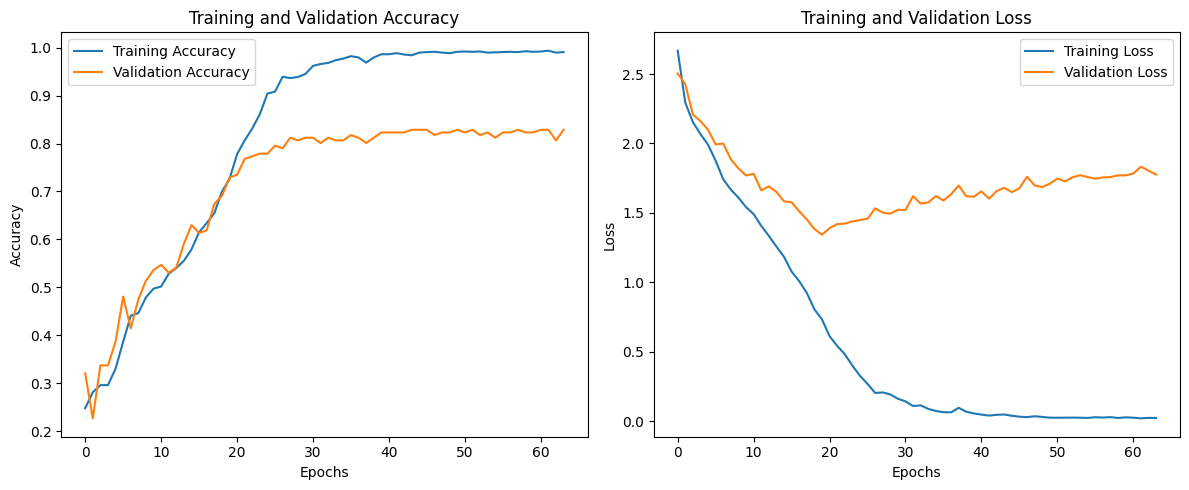

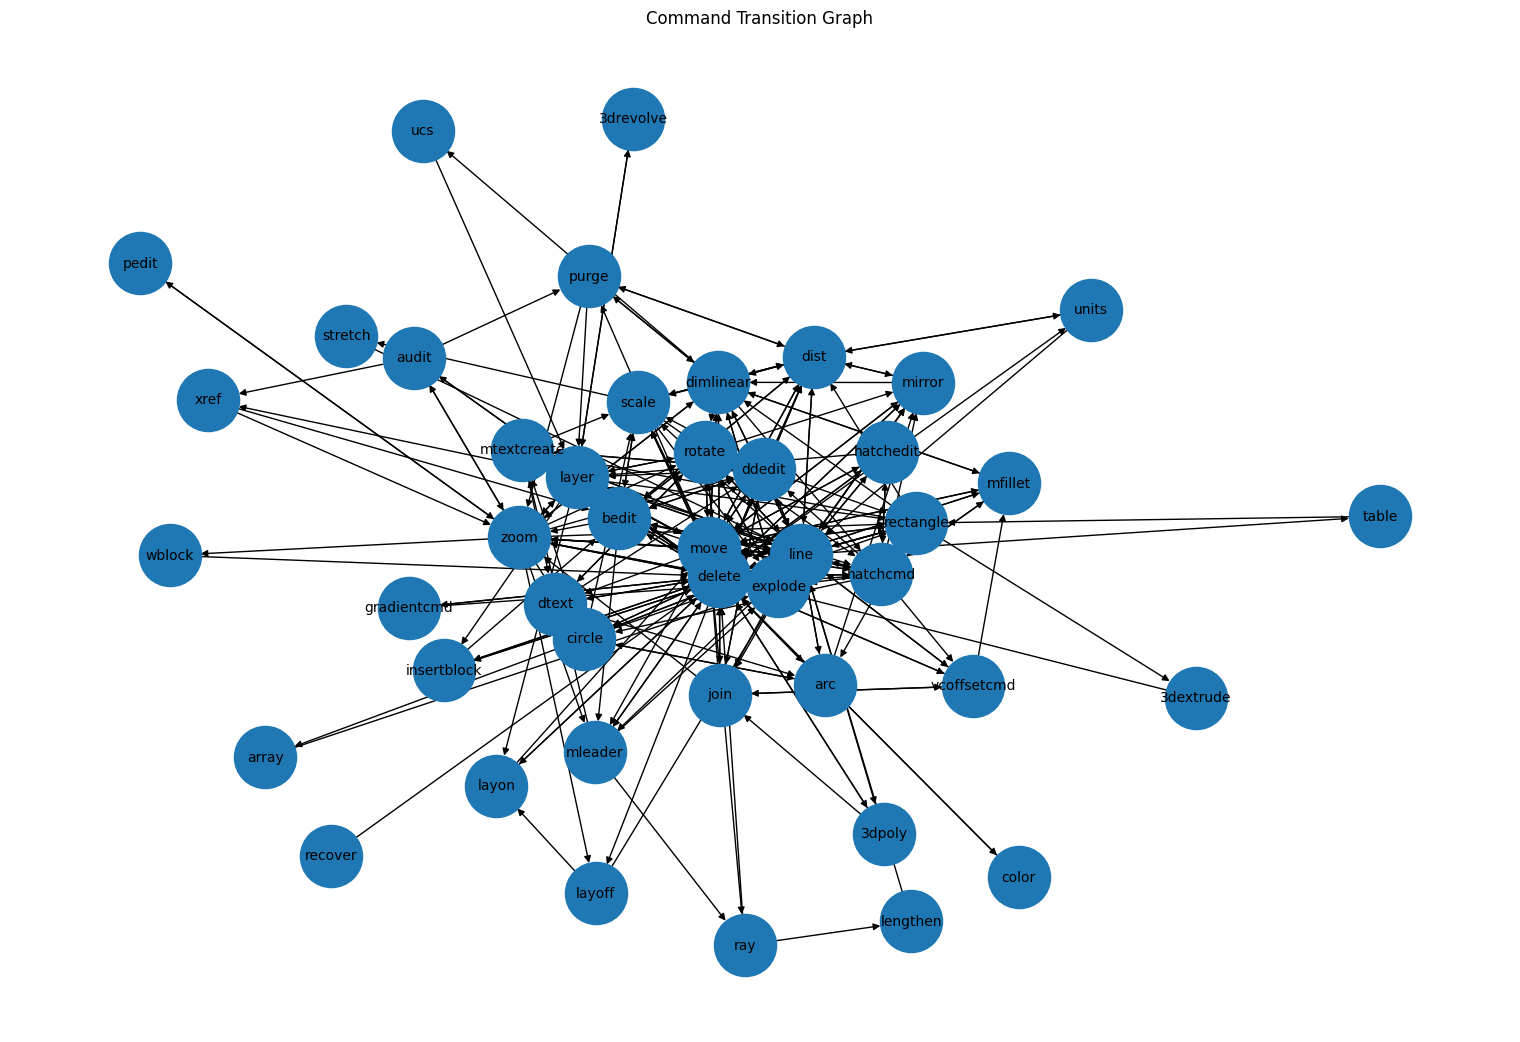

<Figure size 1000x600 with 0 Axes>

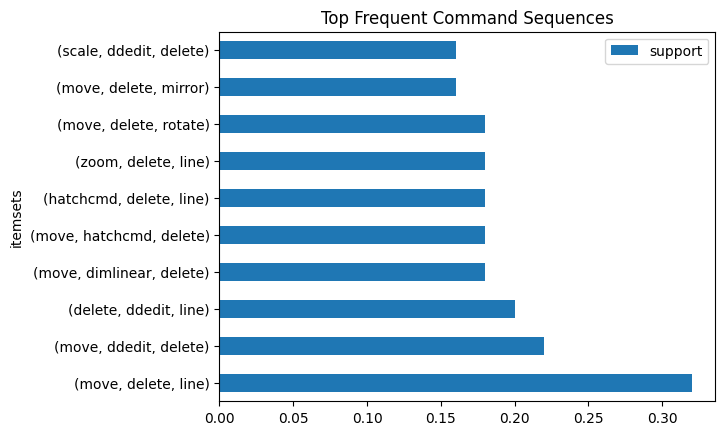

In [ ]:
# Обучение моделей
with tf.device('/GPU:0'):
    analyzer.train_models(corpus, epochs=64)

In [ ]:
import random

def generate_block_with_model(analyzer, seed_sequence, categories, max_block_length=3, num_blocks=1):
    """Генерация блоков с помощью seq2seq модели"""
    # Фильтрация и нормализация входных команд
    seed_list = seed_sequence.lower().split()
    seed_list = [cmd for cmd in seed_list if cmd in categories]
    if not seed_list:
        return []
    #print(f"{seed_list=}")

    # Преобразование в последовательность индексов
    sequence = analyzer.tokenizer.texts_to_sequences([' '.join(seed_list)])
    if not sequence:
        return []
    sequence = sequence[0]
    #print(f"{sequence=}")

    generated_macros = []
    for _ in range(num_blocks):
        current_pred = []
        current_seq_with_pred = sequence.copy()
        cur_max_block_length = max_block_length
        #cur_max_block_length = random.randint(2, max_block_length)
        #print(f"{cur_max_block_length=}")
        #print(f"{current_seq_with_pred=}")
        # Генерация новых команд пока не достигнем максимальной длины
        for i in range(0, cur_max_block_length):
            # Подготовка входных данных для модели
            input_seq = current_seq_with_pred[-(analyzer.max_seq_len-1):]
            padded_input = pad_sequences([input_seq], maxlen=analyzer.max_seq_len-1, padding='pre')

            # Предсказание следующей команды
            predictions = analyzer.model.predict(padded_input, verbose=0)[0]
            #print(f"{predictions=}")

            all_indices = np.argsort(predictions)[:][::-1]
            filtered_indices = [idx for idx in all_indices if analyzer.tokenizer.index_word.get(idx, '') in categories and idx not in current_pred]
            #print(f"{filtered_indices=}")
            if len(filtered_indices) <= 0:
              continue

            top_indices = filtered_indices[-3:] # Топ-3 предсказания
            #print(f"{top_indices=}")
            if top_indices is None or len(top_indices) <= 0:
              continue

            next_index = top_indices[0]
            #next_index = random.choice(top_indices)  # Случайный выбор из топ-3
            #print(f"{next_index=}")

            next_command = analyzer.tokenizer.index_word.get(next_index, '')
            # Проверка валидности команды
            if not next_command or next_command not in categories:
                continue

            current_pred.append(next_index)
            current_seq_with_pred.append(next_index)

        # Преобразование индексов в команды
        macro_commands = [analyzer.tokenizer.index_word.get(idx, '') for idx in current_pred]
        macro_commands = [cmd for cmd in macro_commands if cmd in categories]

        #sIdx = random.randint(0, max_macro_length - 2)
        #eIdx = random.randint(2, max_macro_length)
        #if sIdx > eIdx: eIdx = sIdx;
        #if sIdx == eIdx: eIdx = max_macro_length;
        generated_macros.append(macro_commands)

    return generated_macros

def generate_suggestions(analyzer, seed_command, num_predictions=3, num_macros=3):
    """Генерация предложений на основе текущего контекста"""
    if not analyzer.max_seq_len:
        raise ValueError("Model not trained yet. Call train_models() first")

    # Предсказание следующих команд
    sequence = analyzer.tokenizer.texts_to_sequences([seed_command])
    if not sequence:
        return {'predictions': [], 'macros': []}

    sequence = pad_sequences(sequence, maxlen=analyzer.max_seq_len-1, padding='pre')
    predictions = analyzer.model.predict(sequence)[0]
    top_indices = np.argsort(predictions)[-num_predictions:][::-1]
    predicted_commands = [
        analyzer.tokenizer.index_word.get(idx, '')
        for idx in top_indices
        if analyzer.tokenizer.index_word.get(idx, '') in analyzer.command_categories
    ]

    # Генерация макросов с помощью модели
    neural_macros = generate_block_with_model(
        analyzer,
        seed_command,
        analyzer.command_categories,
        max_block_length=3,
        num_blocks=1
    )

    # Форматирование макросов для nanoCAD
    formatted_macros = []
    for macro in neural_macros:
        # Убираем дубликаты подряд идущих команд
        cleaned_macro = []
        prev_cmd = None
        for cmd in macro:
            if cmd != prev_cmd:
                cleaned_macro.append(cmd.upper())
            prev_cmd = cmd
        formatted_macros.append(f"^C^C_{';'.join(cleaned_macro)};")

    # Генерация предложений по блокам
    block_suggestions = generate_block_with_model(
        analyzer,
        seed_command,
        analyzer.block_categories,
        max_block_length=5,
        num_blocks=1)
    formatted_blocks = []
    for block in block_suggestions:
        # Убираем дубликаты в блоке
        unique_objs = []
        for obj in block:
            if obj not in unique_objs:
                unique_objs.append(obj)
        formatted_blocks.append(f"{';'.join(unique_objs)}")

    return {
        'predictions': predicted_commands,
        'macros': formatted_macros,
        'blocks': formatted_blocks
    }

# Генерация предложений
user_log_commands = 'move rotate line rotate circle line'
suggestions = generate_suggestions(analyzer, user_log_commands)
print("Input row:", user_log_commands)
print("Predicted next commands:", suggestions['predictions'])
print("Suggested neural macros:", suggestions['macros'])
print("Suggested neural blocks:", suggestions['blocks'])

#Используйте ^C^C для отмены текущей команды перед запуском макроса.
#Разделяйте команды символом ; (точка с запятой).
#Для ввода пользователя добавьте \\ (пауза для выбора точек/объектов).
#Комбинируйте команды с системными переменными, например: ^C^C_SETVAR;HIGHLIGHT;0;.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input row: move rotate line rotate circle line
Predicted next commands: ['move', 'rotate', 'rectangle']
Suggested neural macros: ['^C^C_PEDIT;RECOVER;INSERTBLOCK;']
Suggested neural blocks: ['3dpoly;rectangle;line;circle']


In [ ]:
# Сохранение моделей
analyzer.save_models('./models')